# Optimization for Machine Learning: Computer Lab 1

## 2. Preprocessing the data

Here, we load the data, standardize it, and set it in the appropriate shape for performing linear regression. You do not need to complete anything in this section; however it is important that you understand what the code is doing. See the pdf instructions for more details.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Loading data
data_matrix_train, COP_train, data_matrix_test, COP_test, names = np.load('data_center_data_matrix.npy', allow_pickle=True)

In [6]:
data_matrix_train.shape

(722, 892)

In [7]:
# centering and normalizing the matrix
matrix_mean = np.mean(data_matrix_train, axis=0)
M = data_matrix_train - matrix_mean

matrix_std = np.std(M, axis=0)
M = M / matrix_std

In [8]:
M.shape

(722, 892)

In [9]:
COP_train.shape

(722, 4)

In [10]:
# Building the corresponding matrices A,b for linear regression
A = np.hstack([M, np.ones((M.shape[0],1)), -(M.T * COP_train[:,3]).T])
b = COP_train[:,3]

# Building the same matrices for the test set
M_test = (data_matrix_test - matrix_mean) / matrix_std
A_test = np.hstack([M_test, np.ones((M_test.shape[0],1)), -(M_test.T * COP_test[:,3]).T])
b_test = COP_test[:,3]

d = A.shape[1]

## 3. Ordinary least squares

We now wish to solve the problem
$$
\min_{w \in \mathbb{R}^d} \frac 12 \|Aw-b\|_2^2
$$

In [12]:
## Question 3.2: solve with the numpy least squares solver
from numpy.linalg import lstsq
# COMPLETE HERE

w_least_squares, residuals, rank, s = lstsq(A, b, rcond=None)
print("Weights from least squares:", w_least_squares)
print("Weights shape:", w_least_squares.shape)

Weights from least squares: [-0.00927821  0.08309371 -0.03672704 ...  0.01980595 -0.03057174
 -0.01188614]
Weights shape: (1785,)


In [13]:
## Question 3.3

# COMPLETE HERE
test_error = np.mean((A_test @ w_least_squares - b_test)**2)
print("Test error for least squares solution : ", test_error)

Test error for least squares solution :  780.8984793523363


### Adding $\ell_2$ regularization

In order to improve the performance on the test set, we add $\ell_2$ regularization:

$$
\min_{w \in \mathbb{R}^d} \frac 12 \|Aw-b\|_2^2 + \frac \lambda 2 \|w\|_2^2
$$

In [14]:
lambda_l2 = 1e4

In [30]:
# Question 3.5
def f(w):
    return 0.5*np.linalg.norm(A@w -b)**2 + 0.5*lambda_l2*np.linalg.norm(w)**2

def grad_f(w):
    return A.T@(A@w - b) + lambda_l2*w

def gradient_descent(f, grad_f, w0, gamma, max_iter):
    w = w0.copy()
    
    f_values = []
    gradient_norms = []

    for t in range(max_iter):
        # COMPLETE HERE 
        w = w - gamma * grad_f(w)
        
        f_values.append(f(w))
        gradient_norms.append(np.linalg.norm(grad_f(w)))

        if max_iter >= 10 and t % (max_iter // 10) == 0:
            print(f"Iteration {t}: f(w) = {f_values[-1]}, ||grad_f(w)|| = {gradient_norms[-1]}")
        if np.linalg.norm(grad_f(w)) < 1:
            print(f"Converged at iteration {t}")
            break
    return w, f_values, gradient_norms

For finding the appropriate step size range, we need to estimate the Lipschitz constant of the gradient.

In [22]:
# COMPLETE HERE
L = np.linalg.norm(A.T @ A, 2) + lambda_l2
gamma = 1.0 / L
print("Lipschitz constant L:", L)
print("Step size gamma:", gamma)

Lipschitz constant L: 3502543.105358824
Step size gamma: 2.855068360101034e-07


In [32]:
# COMPLETE HERE
w0 = np.zeros(d)
step_size = 1.0 / L
max_iter = 5000

w_GD, f_values_GD, gradient_norms_GD = gradient_descent(f, grad_f, w0, step_size, max_iter)

Iteration 0: f(w) = 5085.233486478005, ||grad_f(w)|| = 33979.21940525627
Iteration 500: f(w) = 2880.65264637355, ||grad_f(w)|| = 550.9651405033994
Iteration 1000: f(w) = 2869.8187849994665, ||grad_f(w)|| = 83.60955980945384
Iteration 1500: f(w) = 2869.5413897118283, ||grad_f(w)|| = 15.033368311265173
Iteration 2000: f(w) = 2869.5319565128775, ||grad_f(w)|| = 2.9372336059000874
Converged at iteration 2339


We now compute the evolution of function values and gradient norm. 

Text(0, 0.5, 'Function values')

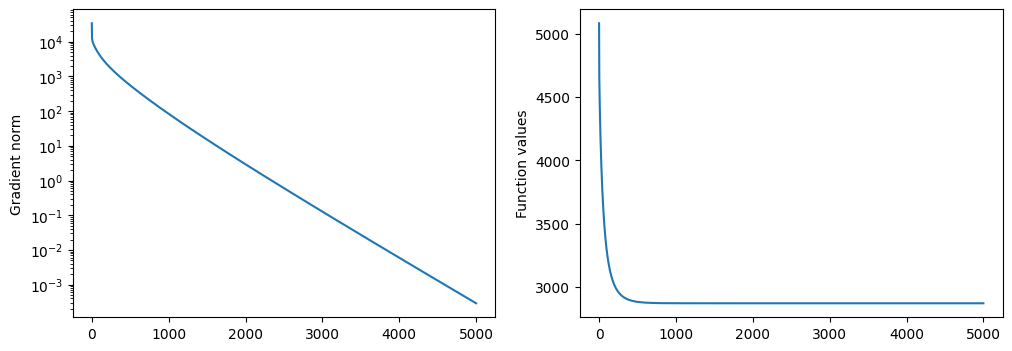

In [29]:
# let us plot the result 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].plot(gradient_norms_GD)
axes[0].semilogy()
axes[0].set_ylabel("Gradient norm")

axes[1].plot(f_values_GD)
axes[1].set_ylabel("Function values")

In [33]:
# Question 3.6 

test_error_l2 = np.mean((A_test @ w_GD - b_test)**2)
print("Test error for l2 penalized solution : ", test_error_l2)

Test error for l2 penalized solution :  61.522725283027825


What do you observe ?

### Line search

The step size given by theory is can be too conservative in practice. We propose to implement a backtracking line search procedure to find a better one automatically.


In [ ]:
# Question 3.7

def gradient_descent_line_search(f, grad_f, w0, gamma_0, max_iter):
    w = w0.copy()
    
    # initial step size
    gamma = gamma_0 
    
    f_values = []
    gradient_norms = []

    for t in range(max_iter):
        # COMPLETE HERE
        grad = grad_f(w)
        while True:
            w_new = w - gamma*grad
            if f(w_new) <= f(w) + grad.T @ (w_new - w) + (1/(2*gamma))*np.linalg.norm(w_new - w)**2:
                break
            
            gamma = gamma / 2

        w = w_new
        gamma = gamma * 2 
        
        f_values.append(f(w))
        gradient_norms.append(np.linalg.norm(grad))

        if max_iter >= 10 and t % (max_iter // 10) == 0:
            print(f"Iteration {t}: f(w) = {f_values[-1]}, [grad_f(w)] = {gradient_norms[-1]}")

        if np.linalg.norm(grad_f(w)) < 1:
            print(f"Converged at iteration {t}")
            break
        
    return w, f_values, gradient_norms

In [42]:
# COMPLETE HERE
w0 = np.zeros(d)
step_size = 1.0
max_iter = 3000

w_GD_LS, f_values_GD_LS, gradient_norms_GD_LS = gradient_descent_line_search(f, grad_f, w0, step_size, max_iter)

Iteration 0: f(w) = 5230.115733687502, [grad_f(w)] = 120927.59130301421
Iteration 300: f(w) = 2870.761289756494, [grad_f(w)] = 182.20417445187508
Iteration 600: f(w) = 2869.5371529144477, [grad_f(w)] = 25.20738082529371
Converged at iteration 890


Text(0, 0.5, 'Function values with line search')

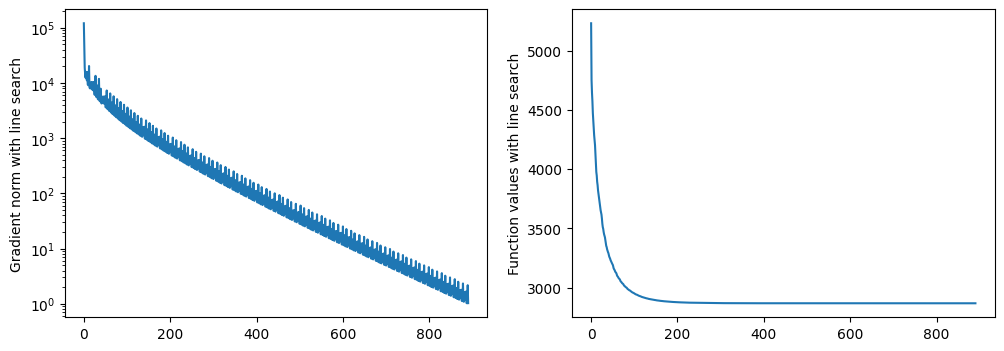

In [43]:
# let us plot the result 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].plot(gradient_norms_GD_LS)
axes[0].semilogy()
axes[0].set_ylabel("Gradient norm with line search")

axes[1].plot(f_values_GD_LS)
axes[1].set_ylabel("Function values with line search")

### Accelerated gradient method
For a faster algorithm, we could implement accelerated gradient descent.

In [44]:
# Question 3.8 (optional) 

def accelerated_gradient_descent(f, grad_f, w0, gamma, max_iter):
    w = w0.copy()
    w_prev = w0.copy()
    y_prev = w0.copy()
    y = w0.copy()
    
    f_values = []
    gradient_norms = []

    for t in range(max_iter):
        # COMPLETE HERE
        y = w - gamma * grad_f(w)
        beta = (t + 1) / (t + 4)
        w = y + beta * (y - y_prev)
        y_prev = y
        f_values.append(f(w))
        gradient_norms.append(np.linalg.norm(grad_f(w)))

        if max_iter >= 10 and t % (max_iter // 10) == 0:
            print(f"Iteration {t}: f(w) = {f_values[-1]}, [grad_f(w)] = {gradient_norms[-1]}")
        if np.linalg.norm(grad_f(w)) < 1:
            print(f"Converged at iteration {t}")
            break
    return w, f_values, gradient_norms

In [45]:
# COMPLETE HERE
w0 = np.zeros(d)
step_size = 1.0 / L
max_iter = 3000

w_AGD, f_values_AGD, gradient_norms_AGD = accelerated_gradient_descent(f, grad_f, w0, step_size, max_iter)

Iteration 0: f(w) = 5051.971650148654, [grad_f(w)] = 37994.73161234013
Iteration 300: f(w) = 2869.563410521285, [grad_f(w)] = 31.07522661035011
Iteration 600: f(w) = 2869.5329057503905, [grad_f(w)] = 6.020679119119379
Iteration 900: f(w) = 2869.5317056393073, [grad_f(w)] = 1.882488292346944
Converged at iteration 1079


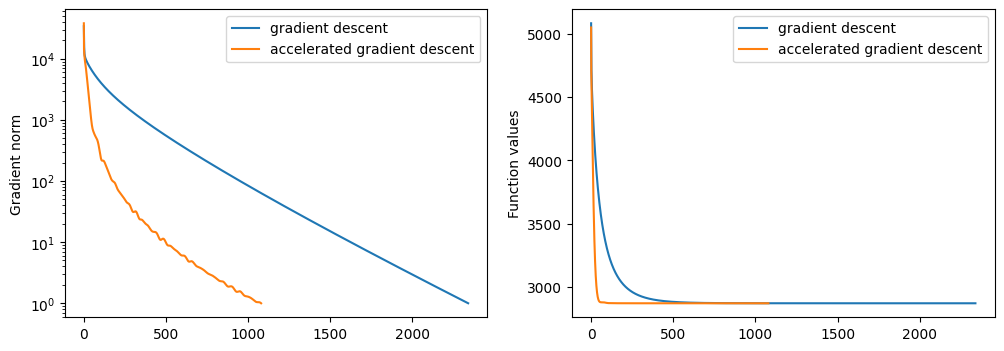

In [46]:
# let us plot the result 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].plot(gradient_norms_GD, label = "gradient descent")
axes[0].plot(gradient_norms_AGD, label = "accelerated gradient descent")
axes[0].semilogy()
axes[0].set_ylabel("Gradient norm")
axes[0].legend()

axes[1].plot(f_values_GD, label = "gradient descent")
axes[1].plot(f_values_AGD, label = "accelerated gradient descent")
axes[1].set_ylabel("Function values")
axes[1].legend()

What do you observe regarding the convergence speed ?

## 4. Adding $\ell_1$ regularization (Lasso)

We now solve 

$$
\min_{w \in \mathbb{R}^d} \frac 12 \|Aw-b\|_2^2 + \lambda \|w\|_1
$$

In [ ]:
lambda_l1 = 1e3

## Question 4.2
def prox_l1(x, mu = 1.):
    """compute the proximal operator of mu * |x|_1
    """
    # COMPLETE HERE
    # ....

def proximal_gradient_descent(f, grad_f, w0, gamma, max_iter):
    w = w0.copy()

    f_values = []
    gradient_norms = []

    for t in range(max_iter):
        # COMPLETE HERE
        # w = ....

        f_values.append(f(w))
        gradient_norms.append(np.linalg.norm(grad_f(w)))
        
    return w, f_values, gradient_norms

In [ ]:
# COMPLETE HERE
w0 = ...
step_size = ...
max_iter = ...

w_PGD, f_values_PGD, gradient_norms_PGD = proximal_gradient_descent(f, grad_f, w0, step_size, max_iter)

In [ ]:
# Question 4.3

test_error_l1 = # COMPLETE HERE
print("Test error for l1 penalized solution : ", test_error_l1)

Compare with the previous test errors. What do you observe?

In [ ]:
# Let us examine the solution
plt.plot(w_GD, label = "l2 solution")
plt.plot(w_PGD, label = "l1 solution")
plt.legend()

What do you observe regarding the difference in **structure** of the two solutions?

## [BONUS] Tuning the penalization parameter

How to find the best solution among all those that were comptued? How to choose the penalization parameter $\lambda$?

In [19]:
# Your method here...